## My first Markov Chain

Tasks
1. Start off on a cloud day.
2. Implement your weather forecast based on the above probabilities
3. Run your simulator for N days 
4. Prepare a plot with the number of days on the x axis and the cumulative fraction of, say, sunny days over the number of days so far on the y axis. This is called a trace-plot, showing how our estimate of $p(\text{clear})$ evolves as the chain samples.
5. Prepare a histogram of the above plot. This reveals the distribution of $p(\text{clear})$.
6. Use a summary statistics to determine the most likely value and an error on our estimate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PSN = 0.5 # probabilità di avere sole domani dato che oggi è nuvolo
PNS = 0.1 # probabilità di avere nuvolo domani dato che oggi c'è sole
PSS = 0.9 # probabilità di avere sole domani dato che oggi c'è sole
PNN = 0.5 # probabilità di avere nuvolo domani dato che oggi è nuvolo

0 for cloudy\
1 for sunny

In [3]:
N = int(1e4) # number of extractions

In [4]:
def MC(condition):
    """
    This function implements the Markov Chain method to estimate the probability of a given sequence of events.
        
    Parameters:
    - condition (int): 0 for cloudy today, 1 for sunny today
    
    Returns:
    - int: 0 for cloudy tomorrow, 1 for sunny tomorrow
    """
    if condition == 0:
        return np.random.choice([0, 1], p=[PNN, PSN])
    else:
        return np.random.choice([0, 1], p=[PNS, PSS])

def weather(value):
    if round(value) == 0:
        return 'Cloudy'
    else:
        return 'Sunny'

In [5]:
initial_weather = 0 # Start from a cloudy day

In [6]:
chain = [initial_weather]

In [7]:
for i in range(N):
    chain.append(MC(chain[i]))

In [8]:
print(f'Cloudy probability:{np.sum(chain)/N :.3}')
print(f'Sunny  probability:{1 - np.sum(chain)/N :.3}')

Cloudy probability:0.839
Sunny  probability:0.161


In [9]:
chain = np.array(chain)

In [10]:
# Masks for sunny and rainy
sunny = (chain == 1).astype(int)
rainy = (chain == 0).astype(int)

# Cumulative sums
sunny_cum = np.cumsum(sunny)
rainy_cum = np.cumsum(rainy)

In [11]:
xax = np.linspace(0,N+1,N+1)

In [12]:
sunny_trace = sunny_cum/(xax+1)
rainy_trace = rainy_cum/(xax+1)

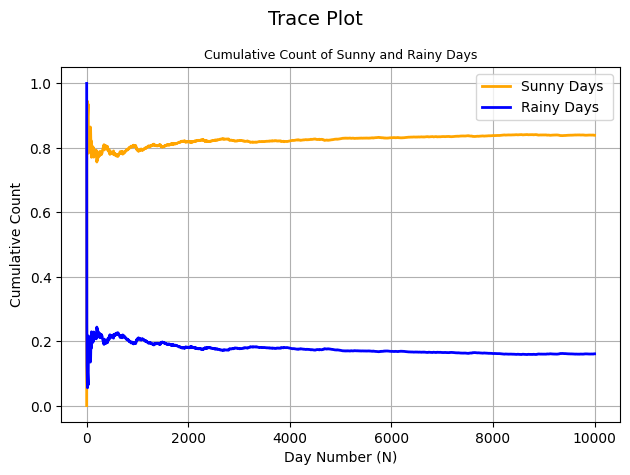

In [13]:
plt.plot(xax, sunny_trace, label='Sunny Days ', color='orange', linewidth=2)
plt.plot(xax, rainy_trace, label='Rainy Days ', color='blue', linewidth=2)
plt.xlabel("Day Number (N)")
plt.ylabel("Cumulative Count")
plt.suptitle('Trace Plot', fontsize=14)
plt.title("Cumulative Count of Sunny and Rainy Days", fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


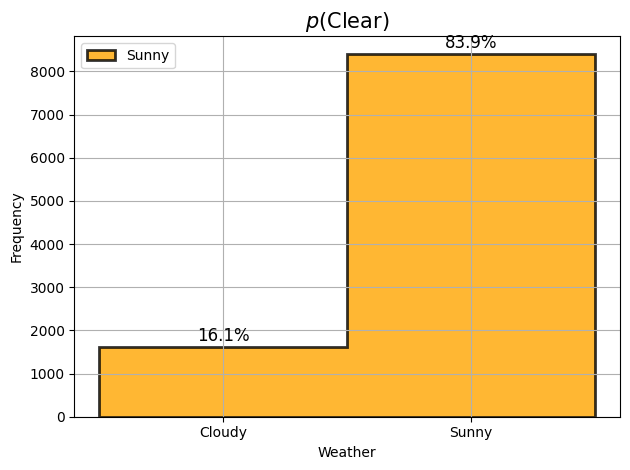

In [14]:
counts, bins, _ = plt.hist(
    sunny,
    bins=2,
    alpha=0.8,
    label='Sunny',
    histtype='stepfilled',
    color='orange',
    edgecolor='black',
    linewidth=2
)

plt.title(r'$p(\text{Clear})$', fontsize=15)
plt.ylabel('Frequency')
plt.xlabel('Weather')

# Set x-axis ticks to custom labels
plt.xticks([0.25, 0.75], ['Cloudy', 'Sunny'])

plt.legend()
plt.grid(True)
plt.tight_layout()


total = np.sum(counts)
for i in range(len(counts)):
    percent = 100 * counts[i] / total
    plt.text(bins[i] + 0.25, counts[i] + 150, f'{percent:.1f}%', ha='center', fontsize=12)



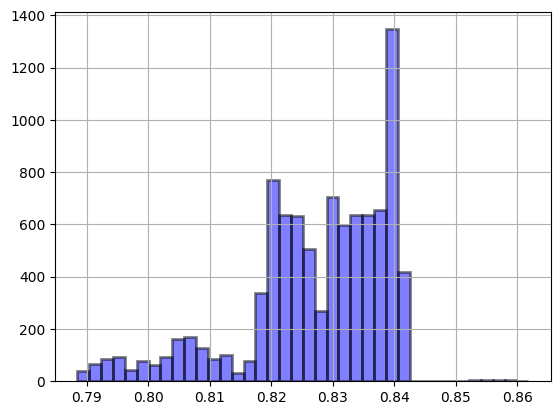

In [15]:
counts, bins, _  = plt.hist(np.cumsum(chain)/(xax+1), bins='scott', alpha=0.5, label='Sunny', color='blue', edgecolor='black', linewidth=2, range=[sunny_trace.mean()-2*sunny_trace.std(),sunny_trace.mean()+2*sunny_trace.std()])
plt.grid()

In [16]:
print(f'Most likely value is : {bins[np.argmax(counts)]:.5} +/- {(bins[2]-bins[1])*0.5:.5}')

Most likely value is : 0.83863 +/- 0.00096491


Looking at the Trace plot, the initial 2000 values oscilate too much thus they need to be discarded.\
Let's quantify this computing the $\sigma_{\mu}$ as a function of some values of $N_{burn}$.

In [17]:
burn_points = np.linspace(200,8000,10, dtype=int)

In [18]:
burn_sunny =  [sunny_trace[:p].std()/sunny_trace.std() for p in burn_points]

Text(0.5, 1.0, 'Trace plot Standard deviation')

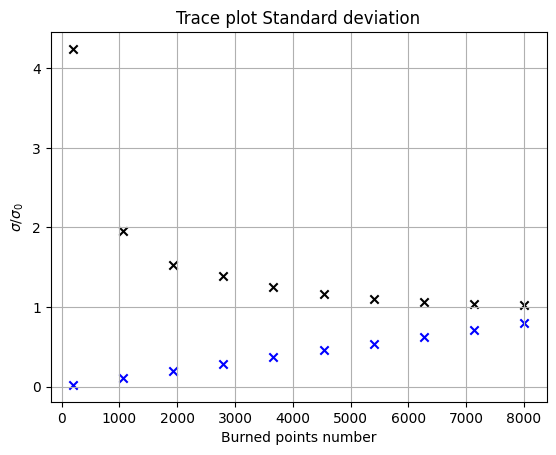

In [19]:
plt.scatter(burn_points, burn_sunny, color='black', label='Burn Points', marker='x')
plt.scatter(burn_points, [1-(len(sunny)-b)/len(sunny) for b in burn_points], color='blue', label='Burn Points', marker='x')
plt.grid()
plt.ylabel(r'$\sigma\text{/}\sigma_0$')
plt.xlabel('Burned points number')
plt.title('Trace plot Standard deviation')

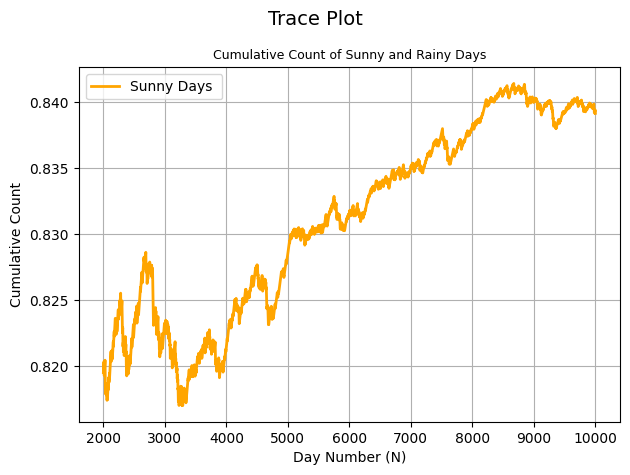

In [20]:
plt.plot(xax[2000:], sunny_trace[2000:], label='Sunny Days ', color='orange', linewidth=2)
plt.xlabel("Day Number (N)")
plt.ylabel("Cumulative Count")
plt.suptitle('Trace Plot', fontsize=14)
plt.title("Cumulative Count of Sunny and Rainy Days", fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Counts')

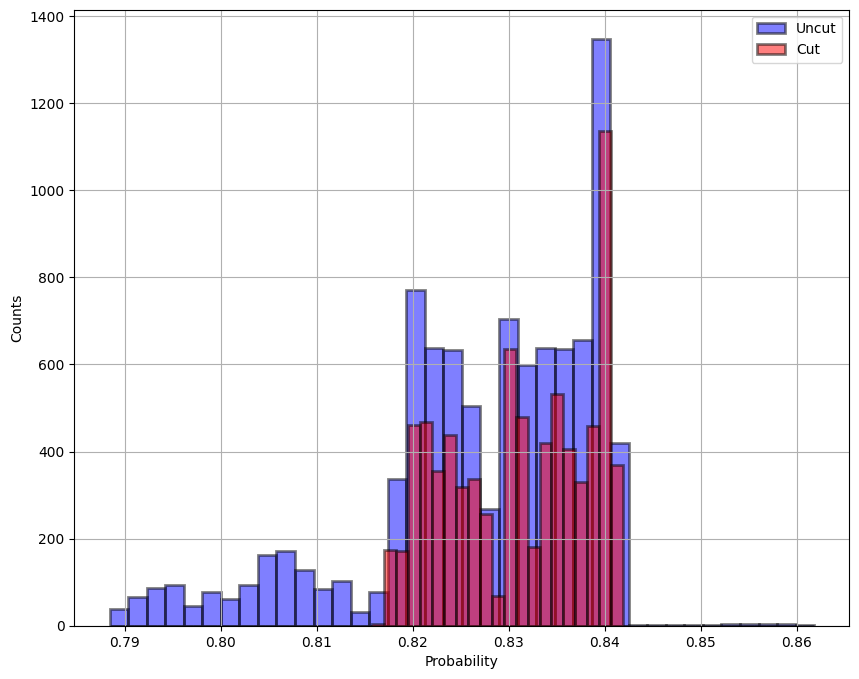

In [21]:
plt.figure(figsize=(10,8))
plt.hist(sunny_trace, bins='scott', alpha=0.5, label='Uncut', color='blue', edgecolor='black', linewidth=2, range=[sunny_trace.mean()-2*sunny_trace.std(),sunny_trace.mean()+2*sunny_trace.std()])
counts2,bins2, _ = plt.hist(sunny_trace[2000:], bins='scott', alpha=0.5, label='Cut', color='red', edgecolor='black', linewidth=2, range=[sunny_trace.mean()-2*sunny_trace.std(),sunny_trace.mean()+2*sunny_trace.std()])
plt.grid()
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Counts')

In [22]:
print(f'Most likely value is : {bins2[np.argmax(counts2)]:.5} +/- {(bins2[2]-bins2[1])*0.5:.5}')

Most likely value is : 0.83941 +/- 0.00062147


Idea 1: as I keep increasing the number of points to be burned, the standard deviation will decrase. the price to pay is to discard some knowledge. Is there a compromise?

In [23]:
chunk_size = int(1e3)

In [24]:
last_bunch = sunny_trace[N-chunk_size:]

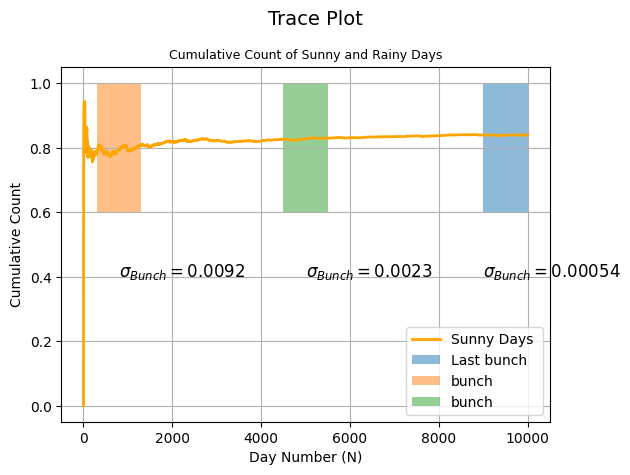

In [25]:
plt.plot(xax, sunny_trace, label='Sunny Days ', color='orange', linewidth=2)
plt.fill_betweenx(np.linspace(0.6, 1, 100), N-chunk_size, N, alpha=0.5, label='Last bunch')
plt.text(N-chunk_size, 0.4, r'$\sigma_{Bunch} = $'+f'{last_bunch.std():.2}', fontsize=12)

centroid = 800
bunch = sunny_trace[int(centroid-0.5*chunk_size):int(centroid+0.5*chunk_size)]
plt.fill_betweenx(np.linspace(0.6, 1, 100), centroid-0.5*chunk_size, centroid+0.5*chunk_size, alpha=0.5, label='bunch')
plt.text(centroid, 0.4, r'$\sigma_{Bunch}= $'+f'{bunch.std():.2}', fontsize=12)

centroid = 5000
bunch = sunny_trace[int(centroid-0.5*chunk_size):int(centroid+0.5*chunk_size)]
plt.fill_betweenx(np.linspace(0.6, 1, 100), centroid-0.5*chunk_size, centroid+0.5*chunk_size, alpha=0.5, label='bunch')
plt.text(centroid, 0.4, r'$\sigma_{Bunch} = $'+f'{bunch.std():.2}', fontsize=12)
plt.xlabel("Day Number (N)")
plt.ylabel("Cumulative Count")
plt.suptitle('Trace Plot', fontsize=14)
plt.title("Cumulative Count of Sunny and Rainy Days", fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()

Another idea is to start from the far right, where the trace plot converges and keep appending trace plot values to an array and look at the standard deviation getting worse, untill it surpasses a certain threshold.

In [26]:
sigma_zero = sunny_trace[N-100:].std()# standard devation of trace values computed on the first 100 values

In [27]:
threshold = 0.008
sigma = [1e-6]
n = 1

In [29]:
while sigma[-1] < threshold:
    if sunny_trace[N - 100 - n - 1000:].std() > sigma[-1]: # check stability    
        sigma.append(sunny_trace[N - 100 - n:].std())
    else:
        pass
    n += 1

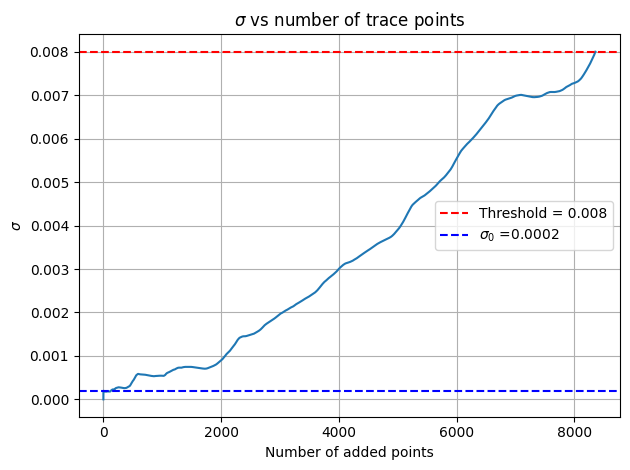

In [30]:
plt.plot(np.linspace(0,len(sigma),len(sigma)),sigma)
plt.axhline(threshold,0,1, linestyle='--',color='r', label=f'Threshold = {threshold:.2}')
plt.axhline(sigma_zero,0,1, linestyle='--',color='b', label=r'$\sigma_{0}$ ='+f'{sigma_zero:.2}')
plt.grid()
plt.title(r'$\sigma$ vs number of trace points')
plt.ylabel(r'$\sigma$')
plt.xlabel('Number of added points')
plt.legend()
plt.tight_layout()

In [31]:
cut = len(sigma)

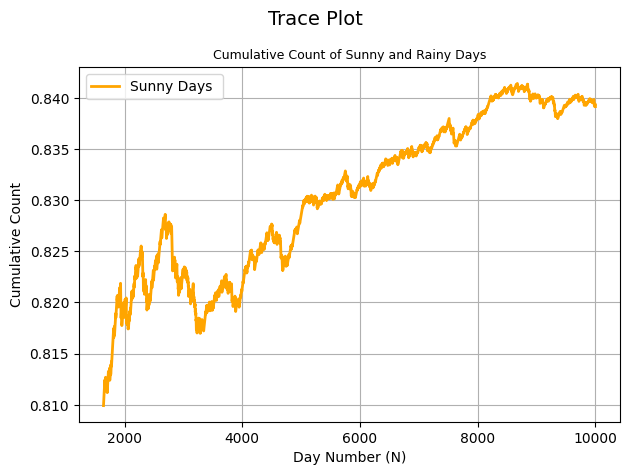

In [32]:
plt.plot(xax[N-cut:], sunny_trace[N-cut:], label='Sunny Days ', color='orange', linewidth=2)
plt.xlabel("Day Number (N)")
plt.ylabel("Cumulative Count")
plt.suptitle('Trace Plot', fontsize=14)
plt.title("Cumulative Count of Sunny and Rainy Days", fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

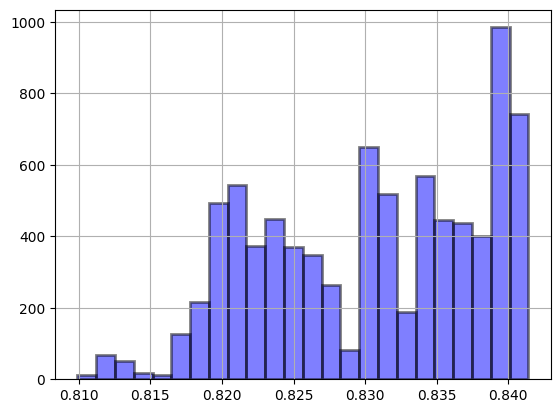

In [33]:
counts3, bins3, _ = plt.hist(sunny_trace[N-cut:], bins='scott', alpha=0.5, label='Sunny', color='blue', edgecolor='black', linewidth=2)
plt.grid()

Error on $\sigma$ is $\sigma_{\sigma} = \frac{\sigma}{\sqrt{2(N-1)}}$.\
From Scott's Rule $\Delta_b = 3.5 \frac{\sigma}{N^{1/3}}$ thus $\sigma_{MLV} = 3.5\frac{\sigma}{N^{1/3}\sqrt{2(N-1)}} \approx 10^{-6}$, too little

In [34]:
err = 3.5 * sunny_trace[N-cut:].std() / (N**(1/3) * np.sqrt(2*(N-1)))
print(f'Most likely value is : {bins3[np.argmax(counts3)]:.5} +/- {(bins3[2]-bins3[1])*0.5:.5}')

Most likely value is : 0.83877 +/- 0.00065603


## Market behaviour

We can do all of the above for the following market scenario

![Alt text](https://camo.githubusercontent.com/4dc8fa4bcc3e22dc8135af250e8626d064afcfbe3752194b70defda62cf70880/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f7468756d622f392f39352f46696e616e63655f4d61726b6f765f636861696e5f6578616d706c655f73746174655f73706163652e7376672f34303070782d46696e616e63655f4d61726b6f765f636861696e5f6578616d706c655f73746174655f73706163652e7376672e706e67)

Since we are now dealing with 3 possible states and since some generality would be great, we'll use another approach.\
Every step of the process will be described by a vector $\vec{v}_i$ whose entries $v_{0}, v_{1}, v_{2}$ represent the weight for every possible state (Stagnant, Bull, Bear).\
To compute $\vec{v}_{i+1}$ we'll apply the transition matrix $T \in \text{Mat}(3\times 3)$ whose entries are the transition probabilities.
The transition matrix $T$ is defined as follows:
$$
T = 
\begin{pmatrix}
T_{00} & T_{01} & T_{02} \\
T_{10} & T_{11} & T_{12} \\
T_{20} & T_{21} & T_{22} \\
\end{pmatrix}
$$
where $T_{ij}$ is the probability of transitioning from state $i$ to state $j$

In [35]:
BL_BL = 0.9
BL_BR = 0.025
BL_ST = 0.075

BR_BR = 0.8
BR_BL = 0.15
BR_ST = 0.05

ST_ST = 0.5
ST_BR = 0.25
ST_BL = 0.25

In [36]:
# Transition matrix
T = [
    [BL_BL, BL_BR, BL_ST],
    [BR_BL, BR_BR, BR_ST],
    [ST_BL, ST_BR, ST_ST],
]

T = np.array(T)

assert np.allclose(T.sum(axis=1), 1), "Rows of transition matrix must sum to 1"


In [37]:
Trans_num = int(1e5) # number of transitions

In [38]:
current_state = 0
transitions = [current_state]

In [39]:
for i in range(Trans_num - 1):
    # Choose next state based on the current state and transition probabilities
    next_state = np.random.choice([0, 1, 2], p=T[current_state])
    transitions.append(next_state)
    current_state = next_state

In [40]:
axis = np.linspace(0,Trans_num,Trans_num)

In [41]:
bull_trace = np.cumsum(np.array(transitions)==0)/(axis+1)
bear_trace = np.cumsum(np.array(transitions)==1)/(axis+1)
stag_trace = np.cumsum(np.array(transitions)==2)/(axis+1)

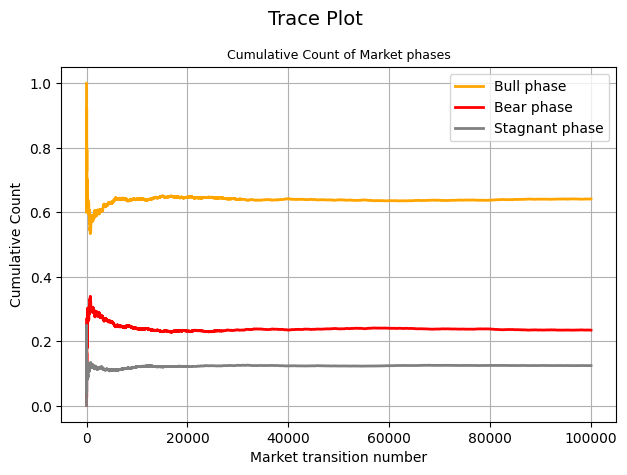

In [42]:
# Plot cumulative counts for each phase
plt.plot(axis, bull_trace , label='Bull phase', color='orange', linewidth=2)
plt.plot(axis, bear_trace , label='Bear phase', color='red', linewidth=2)
plt.plot(axis, stag_trace , label='Stagnant phase', color='grey', linewidth=2)

plt.xlabel("Market transition number")
plt.ylabel("Cumulative Count")
plt.suptitle('Trace Plot', fontsize=14)
plt.title("Cumulative Count of Market phases", fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
bull = bull_trace[int(1e4):]
bear = bear_trace[int(1e4):]
stag = stag_trace[int(1e4):]

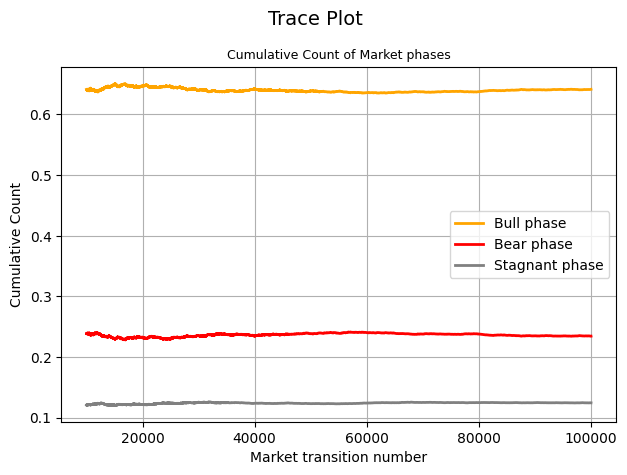

In [44]:
# Plot cumulative counts for each phase
plt.plot(axis[int(1e4):], bull , label='Bull phase', color='orange', linewidth=2)
plt.plot(axis[int(1e4):], bear , label='Bear phase', color='red', linewidth=2)
plt.plot(axis[int(1e4):], stag , label='Stagnant phase', color='grey', linewidth=2)

plt.xlabel("Market transition number")
plt.ylabel("Cumulative Count")
plt.suptitle('Trace Plot', fontsize=14)
plt.title("Cumulative Count of Market phases", fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

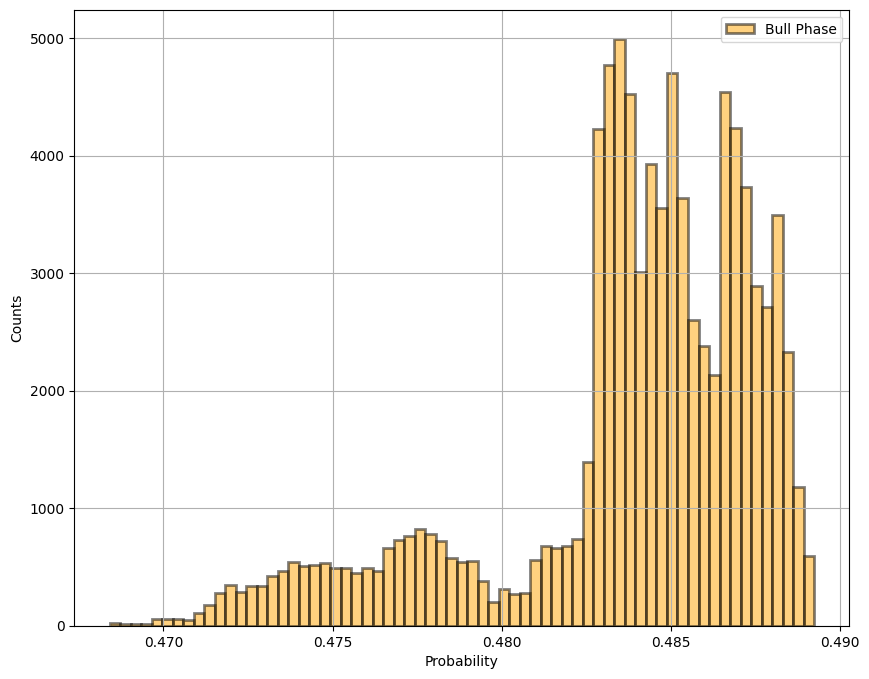

In [45]:
plt.figure(figsize=(10,8))
c,b,_ = plt.hist((np.cumsum(np.array(transitions))/(axis+1))[int(1e4):], bins='scott',alpha=0.5, label='Bull Phase', color='orange', edgecolor='black', linewidth=2)
#plt.hist(bull, bins='scott', alpha=0.5, label='Bull Phase', color='orange', edgecolor='black', linewidth=2)
#plt.hist(bear, bins='scott', alpha=0.5, label='Bear Phase', color='red', edgecolor='black', linewidth=2)
#plt.hist(stag, bins='scott', alpha=0.5, label='Stagnant Phase', color='grey', edgecolor='black', linewidth=2)
plt.grid()
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Counts')

In [46]:
print(f'Most Probable value = {b[np.argmax(c)]:.3} +/- {(b[1] - b[0])/2:.3}')

Most Probable value = 0.483 +/- 0.000155
